<a href="https://colab.research.google.com/github/lamtung1997/Solving_PDEs_Deep_learning/blob/main/2_Stokes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# SETUP
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import time
import math
import itertools
import os
import logging
from numpy import loadtxt
import matplotlib.pyplot as plt

# number pi
pi = math.pi

# random_seed
np.random.seed(1)
tf.random.set_seed(1)

In [2]:
# DATA

n = 50                      # number of points in a border
c = np.linspace(0, 1, n)    # coordinates from 0 to 1 with uniform distribution
P_in, P_up, P_b = [], [], []
for i, j in itertools.product(range(n), range(n)):
    p = [c[i], c[j]]
    if(j == n-1 and i != 0 and i != n-1):
        P_up.append(p)
    elif(i == 0 or i == n-1 or j == 0):
        P_b.append(p)
    else:
        P_in.append(p)

# upsampling P_up that its size is equal to P_in
for i in range(len(P_in)-len(P_up)):
    j = i%(len(P_up))
    P_up.append(P_up[j])

# upsampling P_b that its size is equal to P_in
for i in range(len(P_in)-len(P_b)):
    j = i%(len(P_b))
    P_b.append(P_b[j])

# convert numpy array, P_in and P_border to Tensorflow Dataset
P_in = tf.convert_to_tensor(P_in, dtype=tf.float32)
P_up = tf.convert_to_tensor(P_up, dtype=tf.float32)
P_b = tf.convert_to_tensor(P_b, dtype=tf.float32)

batch_size = 1
bs = int(len(P_in))

P_in = tf.data.Dataset.from_tensor_slices((P_in))
P_in = P_in.shuffle(buffer_size=bs).batch(batch_size).prefetch(4).cache()

P_up = tf.data.Dataset.from_tensor_slices((P_up))
P_up = P_up.shuffle(buffer_size=bs).batch(batch_size).prefetch(4).cache()

P_b = tf.data.Dataset.from_tensor_slices((P_b))
P_b = P_b.shuffle(buffer_size=bs).batch(batch_size).prefetch(4).cache()

In [3]:
print("Number of data:", P_up.cardinality().numpy()*batch_size*3)

Number of data: 6912


In [4]:
# MODEL
nn = 32
inputs = keras.Input(shape=(2,), name='points')
hidden_1 = layers.Dense(nn, activation='tanh', name='hidden_1')(inputs)
hidden_2 = layers.Dense(nn, activation='tanh', name='hidden_2')(hidden_1)
hidden_3 = layers.Dense(nn, activation='tanh', name='hidden_3')(hidden_2)
hidden_4 = layers.Dense(nn, activation='tanh', name='hidden_4')(hidden_3)
# hidden_5 = layers.Dense(nn, activation='tanh', name='hidden_5')(hidden_4)
# hidden_6 = layers.Dense(nn, activation='tanh', name='hidden_6')(hidden_5)
# hidden_7 = layers.Dense(nn, activation='tanh', name='hidden_7')(hidden_6)
# hidden_8 = layers.Dense(nn, activation='tanh', name='hidden_8')(hidden_7)
outputs = layers.Dense(3, activation='linear', name="u_v_p")(hidden_4)
model = keras.Model(inputs=inputs, outputs=outputs, name='stokes')
model.summary()

Model: "stokes"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
points (InputLayer)          [(None, 2)]               0         
_________________________________________________________________
hidden_1 (Dense)             (None, 32)                96        
_________________________________________________________________
hidden_2 (Dense)             (None, 32)                1056      
_________________________________________________________________
hidden_3 (Dense)             (None, 32)                1056      
_________________________________________________________________
hidden_4 (Dense)             (None, 32)                1056      
_________________________________________________________________
u_v_p (Dense)                (None, 3)                 99        
Total params: 3,363
Trainable params: 3,363
Non-trainable params: 0
__________________________________________________________

In [5]:
# CHOOSE OPTIMIZER
optimizer = tf.keras.optimizers.Adam()

In [6]:
# TRAIN FUNCTION
@tf.function
def train_step(P_in, P_up, P_b):
    with tf.GradientTape(persistent=True) as tape:
        loss_in, loss_up, loss_b = [0], [0], [0]

        # interior loss
        for i in range(P_in.shape[0]):
            z = tf.reshape(P_in[i], shape=(1,2))
            with tf.GradientTape(persistent=True) as tape1:
                tape1.watch(z)
                with tf.GradientTape(persistent=True) as tape2:  
                    tape2.watch(z)
                    model_vals = model(z)

                    # u, v, p
                    u = model_vals[0][0]
                    v = model_vals[0][1]
                    p = model_vals[0][2]
                # u_, v_, p_
                u_x = tape2.gradient(u, z)[0][0]
                u_y = tape2.gradient(u, z)[0][1]
                v_x = tape2.gradient(v, z)[0][0]
                v_y = tape2.gradient(v, z)[0][1]
                p_x = tape2.gradient(p, z)[0][0]
                p_y = tape2.gradient(p, z)[0][1]
            # u_xx, u_yy, v_xx, v_yy
            u_xx = tape1.gradient(u_x, z)[0][0]
            u_yy = tape1.gradient(u_y, z)[0][1]
            v_xx = tape1.gradient(v_x, z)[0][0]
            v_yy = tape1.gradient(v_y, z)[0][1]

            # calculating loss_in
            loss1 = tf.math.square(u_xx + u_yy - p_x)
            loss2 = tf.math.square(v_xx + v_yy - p_y)
            loss3 = tf.math.square(u_x + v_y)
            loss_in += loss1 + loss2 + loss3

        # upper boundary loss
        for j in range(P_up.shape[0]):
            z = tf.reshape(P_up[j], shape=(1,2))
            model_vals = model(z)

            # calculating u,v
            u = model_vals[0][0]
            v = model_vals[0][1]

            # calculating loss_up
            loss_up += tf.math.square(u-1) + tf.math.square(v)

        # other boundaries loss
        for j in range(P_b.shape[0]):
            z = tf.reshape(P_b[j], shape=(1,2))
            model_vals = model(z)

            # calculating u,v
            u = model_vals[0][0]
            v = model_vals[0][1]

            # calculating loss_up
            loss_b += tf.math.square(u) + tf.math.square(v)
        
        # loss function
        batch_loss = loss_in + loss_up + loss_b
    
    # update weights
    grads = tape.gradient(batch_loss, model.trainable_weights)          # gradient of loss function with respect to w
    optimizer.apply_gradients(zip(grads, model.trainable_weights))      # update w

    return batch_loss

In [7]:
# TRAIN
losses = []
def train(learning_rate):
    optimizer.learning_rate.assign(learning_rate)
    loss = 0
    for (P_in_batch, P_up_batch, P_b_batch) in itertools.zip_longest(P_in, P_up, P_b):
        batch_loss = train_step(P_in_batch, P_up_batch, P_b_batch)
        loss += batch_loss
    losses.append(loss.numpy())

In [8]:
# TRAIN
i = 0
max_ite = 1000
lr = 1e-3
start = time.time()
print("Learning rate:", lr)
while(True):
    start_ite = time.time()
    train(lr)
    if(i%1 == 0):
        print("[%3s] loss = %13.7f \t %5.3fs \t less than %5.3f minutes to finish" % (i, losses[i], time.time() - start_ite, (time.time() - start_ite)*(max_ite - i)/60))
    if(i > 200):
        if(losses[i]/np.min(losses[i-200 : i-100]) > 0.99):
            lr = lr/10
            if(lr < 1e-5):
                break
            print("\nNew learning rate:", lr)
    if(i > max_ite):
        break
    i = i + 1


print("Total time: %.2f minutes" % ((time.time() - start)/60))

Learning rate: 0.001
[  0] loss =   447.4832458 	 7.593s 	 less than 126.542 minutes to finish
[  1] loss =   405.8460083 	 4.184s 	 less than 69.656 minutes to finish
[  2] loss =   395.7346802 	 4.149s 	 less than 69.011 minutes to finish
[  3] loss =   380.0872498 	 4.171s 	 less than 69.310 minutes to finish
[  4] loss =   336.2171936 	 4.268s 	 less than 70.842 minutes to finish
[  5] loss =   300.0389099 	 4.275s 	 less than 70.902 minutes to finish
[  6] loss =   282.4236450 	 4.194s 	 less than 69.474 minutes to finish
[  7] loss =   271.6277771 	 4.271s 	 less than 70.693 minutes to finish
[  8] loss =   263.3179321 	 4.420s 	 less than 73.074 minutes to finish
[  9] loss =   257.1058960 	 4.299s 	 less than 70.998 minutes to finish
[ 10] loss =   252.3172455 	 4.330s 	 less than 71.440 minutes to finish
[ 11] loss =   248.3509521 	 4.307s 	 less than 70.987 minutes to finish
[ 12] loss =   244.8575439 	 4.241s 	 less than 69.838 minutes to finish
[ 13] loss =   241.8369293 	 

In [9]:
model.save("/content/drive/My Drive/Colab Notebooks/Keras/Solving PDEs/2. Stokes (generated data)")

INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/Keras/Solving PDEs/2. Stokes (generated data)/assets


In [10]:
model1 = keras.models.load_model("/content/drive/My Drive/Colab Notebooks/Keras/Solving PDEs/2. Stokes (generated data)")

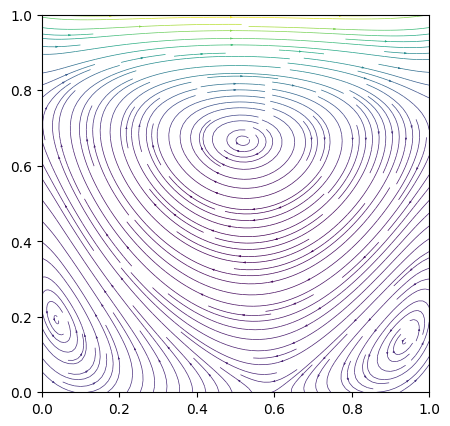

In [11]:
plt.figure(figsize=(5, 5), dpi=100)

n = 20
x = np.linspace(0, 1, n)
y = np.linspace(0, 1, n)

u = np.zeros(shape=(n,n), dtype=float)
v = np.zeros(shape=(n,n), dtype=float)

for i in range(n):
    for j in range(n):
        z = tf.convert_to_tensor([[x[i], y[j]]])
        u1, v1 = model1(z).numpy()[0][0:2]
        u[j,i] = u1
        v[j,i] = v1

plt.streamplot(x, y, u, v, color=u*10, linewidth=0.5, arrowsize=0.25, density=2)
plt.show()